# November 2, 2021 lecture notes

This week we'll take a first look at [Apache Spark](http://spark.apache.org/), a powerful system for scaling up data processing.

Spark is installed on your instances, but requires a few steps to use.  Every time you use Spark, you'll have to run the following steps:

In [7]:
import findspark

In [8]:
findspark.init()

The next two steps are required for the simple Python style of using Spark.  We'll see one other approach later on.

In [9]:
from pyspark import SparkContext

In [10]:
spark = SparkContext(appName='20211102')

21/11/06 20:49:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


The `spark` object is all you need to start doing some pretty cool things.  Let's have a quick look at it.

In [11]:
spark

<SparkContext master=local[*] appName=20211102>

If you have port 4040 open in your EC2 security groups, you can follow the link above to the Spark instance UI on your machine.  There's one caveat though - it maps automatically to an IP address that won't work unless you take extra steps.  The solution is simple:  replace the IP address in the URL with your machine name, the one that starts with "ec2-" that you are probably looking at Jupyter through right now.

**Note**, though, the Spark UI defaults to port 4040, not 8080 like Jupyter, so **be sure you use `:4040`** in your URL.

Have a look now!

## Bikeshare data

Because Capital Bikeshare data is so familiar, let's have a look at it using Spark.  Maybe you've already seen what it looks like at the command line, using CSVKit and XSV, and with SQL.  Now we'll try a functional style of approach.

These first few steps should be familiar.

In [6]:
!wget https://s3.amazonaws.com/capitalbikeshare-data/2017-capitalbikeshare-tripdata.zip

--2021-11-06 19:41:03--  https://s3.amazonaws.com/capitalbikeshare-data/2017-capitalbikeshare-tripdata.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.197.136
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.197.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89576218 (85M) [application/zip]
Saving to: ‘2017-capitalbikeshare-tripdata.zip.1’

2017-capitalbikesha 100%[===================>]  85.43M  76.6MB/s    in 1.1s    

2021-11-06 19:41:04 (76.6 MB/s) - ‘2017-capitalbikeshare-tripdata.zip.1’ saved [89576218/89576218]



In [7]:
!ls -lh 2017-capitalbikeshare-tripdata.zip

-rw-rw-r-- 1 ubuntu ubuntu 86M Mar 15  2018 2017-capitalbikeshare-tripdata.zip


In [8]:
!unzip 2017-capitalbikeshare-tripdata.zip

Archive:  2017-capitalbikeshare-tripdata.zip
replace 2017Q1-capitalbikeshare-tripdata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [9]:
!wc -l 20*.csv

   646511 2017.csv
   646511 2017Q1-capitalbikeshare-tripdata.csv
  1104419 2017Q2-capitalbikeshare-tripdata.csv
  1191586 2017Q3-capitalbikeshare-tripdata.csv
   815265 2017Q4-capitalbikeshare-tripdata.csv
  4404292 total


In [10]:
!csvcut -n 2017Q1-capitalbikeshare-tripdata.csv

  1: Duration
  2: Start date
  3: End date
  4: Start station number
  5: Start station
  6: End station number
  7: End station
  8: Bike number
  9: Member type


In [11]:
!csvcut -n 2017Q3-capitalbikeshare-tripdata.csv

  1: Duration
  2: Start date
  3: End date
  4: Start station number
  5: Start station
  6: End station number
  7: End station
  8: Bike number
  9: Member type


So far so good.

### CSVkit and XSV

To keep these command line pipes simple, let's combine and rename the data into one file:

In [12]:
!cp 2017Q1-capitalbikeshare-tripdata.csv 2017.csv

In [13]:
!head 2017.csv | csvlook

| Duration |          Start date |            End date | Start station number | Start station                               | End station number | End station                | Bike number | Member type |
| -------- | ------------------- | ------------------- | -------------------- | ------------------------------------------- | ------------------ | -------------------------- | ----------- | ----------- |
|      221 | 2017-01-01 00:00:41 | 2017-01-01 00:04:23 |               31,634 | 3rd & Tingey St SE                          |             31,208 | M St & New Jersey Ave SE   | W00869      | Member      |
|    1,676 | 2017-01-01 00:06:53 | 2017-01-01 00:34:49 |               31,258 | Lincoln Memorial                            |             31,270 | 8th & D St NW              | W00894      | Casual      |
|    1,356 | 2017-01-01 00:07:10 | 2017-01-01 00:29:47 |               31,289 | Henry Bacon Dr & Lincoln Memorial Circle NW |             31,222 | New York Ave & 15th St NW  | W21945  

In [14]:
!ls -lh *.csv

-rw-rw-r-- 1 ubuntu ubuntu  86M Nov  6 19:43 2017.csv
-rw-rw-r-- 1 ubuntu ubuntu  86M Mar 15  2018 2017Q1-capitalbikeshare-tripdata.csv
-rw-rw-r-- 1 ubuntu ubuntu 147M Mar 15  2018 2017Q2-capitalbikeshare-tripdata.csv
-rw-rw-r-- 1 ubuntu ubuntu 158M Mar 15  2018 2017Q3-capitalbikeshare-tripdata.csv
-rw-rw-r-- 1 ubuntu ubuntu 108M Mar 15  2018 2017Q4-capitalbikeshare-tripdata.csv
-rw-rw-r-- 1 ubuntu ubuntu 710K Oct 31 15:41 Candidate.csv
-rw-rw-r-- 1 ubuntu ubuntu 2.1M Oct 31 15:41 Committee.csv
-rw-rw-r-- 1 ubuntu ubuntu 360K Oct 31 15:41 Finances.csv
-rw-rw-r-- 1 ubuntu ubuntu 257K Oct 31 15:41 Link.csv
-rw-rw-r-- 1 ubuntu ubuntu 337M Oct 31 15:44 con1.csv
-rw-rw-r-- 1 ubuntu ubuntu 349M Oct 31 15:44 con2.csv
-rw-rw-r-- 1 ubuntu ubuntu 354M Oct 31 15:45 con3.csv
-rw-rw-r-- 1 ubuntu ubuntu 367M Oct 31 15:45 con4.csv
-rw-rw-r-- 1 ubuntu ubuntu 1.4G Oct 31 15:47 contribution.csv
-rw-rw-r-- 1 ubuntu ubuntu 337M Oct 31 15:41 itcont_2016_20160717_20160830.csv
-rw-rw-r-- 1 ubuntu ubuntu 349M

In [15]:
!wc -l *.csv

    646511 2017.csv
    646511 2017Q1-capitalbikeshare-tripdata.csv
   1104419 2017Q2-capitalbikeshare-tripdata.csv
   1191586 2017Q3-capitalbikeshare-tripdata.csv
    815265 2017Q4-capitalbikeshare-tripdata.csv
      7396 Candidate.csv
     17651 Committee.csv
      2906 Finances.csv
      6407 Link.csv
   1908651 con1.csv
   1946525 con2.csv
   1955025 con3.csv
   1988500 con4.csv
   7798698 contribution.csv
   1908652 itcont_2016_20160717_20160830.csv
   1946526 itcont_2016_20160831_20161003.csv
   1955026 itcont_2016_20161004_20161028.csv
   1988501 itcont_2016_20161029_20161202.csv
       821 nny_candidate.csv
       821 ny_candidate.csv
    250193 tweets.csv
  28086591 total


Alright, then, we have 429M of raw data comprising 3,757,777 bikeshare trips.  How long does it take to sort?

First, we take a look at a sample of the data to determine its attributes' domains and ranges.

In [16]:
!head -n 1000 2017.csv | csvstat

  1. "Duration"

	Type of data:          Number
	Contains null values:  False
	Unique values:         752
	Smallest value:        61
	Largest value:         36943
	Sum:                   1204806
	Mean:                  1206.012012
	Median:                649
	StDev:                 2326.380276
	Most common values:    341 (7x)
	                       291 (7x)
	                       311 (5x)
	                       280 (4x)
	                       228 (4x)

  2. "Start date"

	Type of data:          DateTime
	Contains null values:  False
	Unique values:         970
	Smallest value:        2017-01-01 00:00:41
	Largest value:         2017-01-01 12:26:40
	Most common values:    2017-01-01 10:52:33 (3x)
	                       2017-01-01 11:12:43 (3x)
	                       2017-01-01 00:16:08 (2x)
	                       2017-01-01 00:53:33 (2x)
	                       2017-01-01 01:51:23 (2x)

  3. "End date"

	Type of data:          DateTime
	Contains null values:  False
	Unique values:

In [17]:
import os

In [143]:
%time os.system("head -25000 2017.csv | csvsort -c1 | head | csvlook")

| Duration |          Start date |            End date | Start station number | Start station                               | End station number | End station                                 | Bike number | Member type |
| -------- | ------------------- | ------------------- | -------------------- | ------------------------------------------- | ------------------ | ------------------------------------------- | ----------- | ----------- |
|       60 | 2017-01-01 14:11:14 | 2017-01-01 14:12:15 |               31,289 | Henry Bacon Dr & Lincoln Memorial Circle NW |             31,289 | Henry Bacon Dr & Lincoln Memorial Circle NW | W20752      | Casual      |
|       61 | 2017-01-01 11:48:59 | 2017-01-01 11:50:01 |               31,110 | 20th St & Florida Ave NW                    |             31,110 | 20th St & Florida Ave NW                    | W21832      | Member      |
|       61 | 2017-01-04 06:30:55 | 2017-01-04 06:31:56 |               31,102 | 11th & Kenyon St NW                 

0

Is it faster if we sort only one column?

In [142]:
%time os.system("head -25000 2017.csv | csvcut -c1 | csvsort -c1| head | csvlook")

| Duration |
| -------- |
|       60 |
|       61 |
|       61 |
|       61 |
|       62 |
|       63 |
|       64 |
|       64 |
|       64 |
CPU times: user 656 µs, sys: 1e+03 µs, total: 1.66 ms
Wall time: 2.62 s


/home/ubuntu/.local/lib/python3.8/site-packages/agate/table/from_csv.py:72: RuntimeWarning: Error sniffing CSV dialect: Could not determine delimiter


0

What about if we sort using unix `sort` instead of `csvsort`?

In [20]:
%time os.system("head -25000 2017.csv | csvcut -c1 | sort -n| head")

Duration
60
61
61
61
62
63
64
64
64
CPU times: user 1.99 ms, sys: 308 µs, total: 2.3 ms
Wall time: 288 ms


sort: write failed: 'standard output': Broken pipe
sort: write error


0

## Why is `sort` faster than `csvsort`?

## Introducing `xsv`

[`xsv`](https://github.com/BurntSushi/xsv) is another CSV toolkit like CSVKit, but where CSVKit was designed to be easy and consistent, `xsv` was designed to be *fast*.  And it's really fast.

It has a lot of functions similar to CSVKit.

In [21]:
!xsv --help

Usage:
    xsv <command> [<args>...]
    xsv [options]

Options:
    --list        List all commands available.
    -h, --help    Display this message
    <command> -h  Display the command help message
    --version     Print version info and exit

Commands:
    cat         Concatenate by row or column
    count       Count records
    fixlengths  Makes all records have same length
    flatten     Show one field per line
    fmt         Format CSV output (change field delimiter)
    frequency   Show frequency tables
    headers     Show header names
    help        Show this usage message.
    index       Create CSV index for faster access
    input       Read CSV data with special quoting rules
    join        Join CSV files
    sample      Randomly sample CSV data
    search      Search CSV data with regexes
    select      Select columns from CSV
    slice       Slice records from CSV
    sort        Sort CSV data
    split       Split CSV data into many files
    stats       Comput

In [22]:
!head 2017.csv | xsv table

Duration  Start date           End date             Start station number  Start station                                End station number  End station                 Bike number  Member type
221       2017-01-01 00:00:41  2017-01-01 00:04:23  31634                 3rd & Tingey St SE                           31208               M St & New Jersey Ave SE    W00869       Member
1676      2017-01-01 00:06:53  2017-01-01 00:34:49  31258                 Lincoln Memorial                             31270               8th & D St NW               W00894       Casual
1356      2017-01-01 00:07:10  2017-01-01 00:29:47  31289                 Henry Bacon Dr & Lincoln Memorial Circle NW  31222               New York Ave & 15th St NW   W21945       Casual
1327      2017-01-01 00:07:22  2017-01-01 00:29:30  31289                 Henry Bacon Dr & Lincoln Memorial Circle NW  31222               New York Ave & 15th St NW   W20012       Casual
1636      2017-01-01 00:07:36  2017-01-01 00:34:52  31258   

In [23]:
!xsv headers 2017.csv

1   Duration
2   Start date
3   End date
4   Start station number
5   Start station
6   End station number
7   End station
8   Bike number
9   Member type


In [24]:
!xsv search -s5 "Eastern Market / 7th" 2017.csv | xsv select 1,5,7 | head | xsv table

Duration  Start station                                 End station
360       Eastern Market / 7th & North Carolina Ave SE  11th & H St NE
312       Eastern Market / 7th & North Carolina Ave SE  15th St & Massachusetts Ave SE
1960      Eastern Market / 7th & North Carolina Ave SE  Lincoln Memorial
1933      Eastern Market / 7th & North Carolina Ave SE  Lincoln Memorial
290       Eastern Market / 7th & North Carolina Ave SE  15th St & Massachusetts Ave SE
944       Eastern Market / 7th & North Carolina Ave SE  10th & G St NW
722       Eastern Market / 7th & North Carolina Ave SE  5th & F St NW
238       Eastern Market / 7th & North Carolina Ave SE  Lincoln Park / 13th & East Capitol St NE 
317       Eastern Market / 7th & North Carolina Ave SE  14th & D St SE


In [25]:
!xsv select 4 2017.csv | head | xsv table

Start station number
31634
31258
31289
31289
31258
31258
31611
31104
31041


In [26]:
!xsv select 4 2017.csv | xsv frequency | xsv table

field                 value  count
Start station number  31623  13712
Start station number  31200  9071
Start station number  31201  8195
Start station number  31247  8026
Start station number  31258  7876
Start station number  31241  7211
Start station number  31229  6607
Start station number  31101  6563
Start station number  31613  5907
Start station number  31600  5846


In [27]:
!xsv select 1 2017.csv | xsv stats | xsv table

field     type     sum        min  max    min_length  max_length  mean                stddev
Duration  Integer  653262764  60   86066  2           5           1010.4449490340571  2087.020244663465


In [28]:
!xsv sort -s4 2017.csv | head | xsv table

Duration  Start date           End date             Start station number  Start station        End station number  End station          Bike number  Member type
1632      2017-01-04 07:34:02  2017-01-04 08:01:14  31000                 Eads St & 15th St S  31205               21st & I St NW       W21228       Member
968       2017-01-04 10:13:48  2017-01-04 10:29:57  31000                 Eads St & 15th St S  31249               Jefferson Memorial   W20933       Member
1136      2017-01-04 16:35:16  2017-01-04 16:54:13  31000                 Eads St & 15th St S  31249               Jefferson Memorial   W20447       Casual
1809      2017-01-05 07:58:34  2017-01-05 08:28:43  31000                 Eads St & 15th St S  31205               21st & I St NW       W00302       Member
975       2017-01-05 10:08:53  2017-01-05 10:25:08  31000                 Eads St & 15th St S  31249               Jefferson Memorial   W22416       Member
1978      2017-01-06 09:17:26  2017-01-06 09:50:25  31000  

That seemed pretty fast... how fast was it?  Let's try to reproduce our test from before.

In [29]:
%time os.system("xsv select 4 2017.csv | xsv sort | uniq -c | head")

      1 Start station number
    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
CPU times: user 0 ns, sys: 2.87 ms, total: 2.87 ms
Wall time: 1.92 s


uniq: write error: Broken pipe


0

Wow!  That's really fast.  Even faster than unix `sort`!  Let's use `%timeit` to try repeated runs and get a better sample for comparison.

In [30]:
%timeit os.system("xsv select 4 2017.csv | xsv sort | uniq -c | head")

      1 Start station number
    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008


uniq: write error: Broken pipe


      1 Start station number
    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008


uniq: write error: Broken pipe


      1 Start station number
    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008


uniq: write error: Broken pipe


      1 Start station number
    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008


uniq: write error: Broken pipe


      1 Start station number
    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008


uniq: write error: Broken pipe


      1 Start station number
    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008


uniq: write error: Broken pipe


      1 Start station number
    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008


uniq: write error: Broken pipe


      1 Start station number
    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
1.35 s ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


uniq: write error: Broken pipe


In [31]:
%timeit os.system("xsv select 4 2017.csv | sort | uniq -c | head")

    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009
1.21 s ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


uniq: write error: Broken pipe


Just for fun, let's run that again with `csvcut` instead of `xsv select`.

In [32]:
%timeit os.system("csvcut -c4 2017.csv | sort | uniq -c | head")

    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009


uniq: write error: Broken pipe


    299 31000
    385 31001
   1002 31002
    813 31003
    591 31004
   1247 31005
    674 31006
   1631 31007
    877 31008
    849 31009
3.8 s ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


uniq: write error: Broken pipe


Pretty impressive, right?  It was designed to be *fast*.  And it is.

But wait, there's more.  `xsv` supports *indexing*, 

In [33]:
!xsv index 2017.csv

In [34]:
!ls -lh 2017*

-rw-rw-r-- 1 ubuntu ubuntu  86M Mar 15  2018 2017-capitalbikeshare-tripdata.zip
-rw-rw-r-- 1 ubuntu ubuntu  86M Mar 15  2018 2017-capitalbikeshare-tripdata.zip.1
-rw-rw-r-- 1 ubuntu ubuntu  86M Nov  6 19:43 2017.csv
-rw-rw-r-- 1 ubuntu ubuntu 5.0M Nov  6 19:47 2017.csv.idx
-rw-rw-r-- 1 ubuntu ubuntu  86M Mar 15  2018 2017Q1-capitalbikeshare-tripdata.csv
-rw-rw-r-- 1 ubuntu ubuntu 147M Mar 15  2018 2017Q2-capitalbikeshare-tripdata.csv
-rw-rw-r-- 1 ubuntu ubuntu 158M Mar 15  2018 2017Q3-capitalbikeshare-tripdata.csv
-rw-rw-r-- 1 ubuntu ubuntu 108M Mar 15  2018 2017Q4-capitalbikeshare-tripdata.csv


In [35]:
!xsv select 5 2017.csv | xsv frequency | xsv table

field          value                                                count
Start station  Columbus Circle / Union Station                      13712
Start station  Massachusetts Ave & Dupont Circle NW                 9071
Start station  15th & P St NW                                       8195
Start station  Jefferson Dr & 14th St SW                            8026
Start station  Lincoln Memorial                                     7876
Start station  Thomas Circle                                        7211
Start station  New Hampshire Ave & T St NW                          6607
Start station  14th & V St NW                                       6563
Start station  Eastern Market Metro / Pennsylvania Ave & 7th St SE  5907
Start station  5th & K St NW                                        5846


The moral of the story:  different tools with similar goals but different designs can each both achieve their goals effectively.  Knowing which to choose for a particular task requires an understanding of the design tradeoffs.

## Looping vs. Vectorization

Vectorization (or array programming) is a critical piece of the data science puzzle.  Fast implementations of array operations take advantage of low-level hardware to make operations on matrixes very fast, which is critical for machine learning and other statistical operations on large datasets.

To get a taste of the difference vectorized operations work, let's look at a simple function:  finding the largest value in a matrix.  This should have complexity O(n), or linear, as the number of compute operations increases linearly with the size of the input set.

We can use the [pyheatmagic](https://github.com/csurfer/pyheatmagic) Jupyter extension to look at the performance of two versions of a function that find the largest value within a matrix of random numbers.  The larger the matrix size, the larger the result should be - or in this case, the closer to 1.

In [36]:
%load_ext heat

0.9999779242028085


/home/ubuntu/.local/lib/python3.8/site-packages/pyheat/pyheat.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels(row_labels, minor=False)


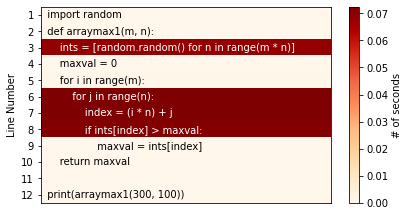

In [37]:
%%heat
import random
def arraymax1(m, n):
    ints = [random.random() for n in range(m * n)]
    maxval = 0
    for i in range(m):
        for j in range(n):
            index = (i * n) + j
            if ints[index] > maxval:
                maxval = ints[index]
    return maxval

print(arraymax1(300, 100))

0.9999973369219253


/home/ubuntu/.local/lib/python3.8/site-packages/pyheat/pyheat.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels(row_labels, minor=False)


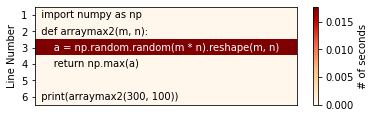

In [137]:
%%heat
import numpy as np
def arraymax2(m, n):
    a = np.random.random(m * n).reshape(m, n)
    return np.max(a)

print(arraymax2(300, 100))

In [138]:
import random
def arraymax1(m, n):
    ints = [random.random() for n in range(m * n)]
    maxval = 0
    for i in range(m):
        for j in range(n):
            index = (i * n) + j
            if ints[index] > maxval:
                maxval = ints[index]
    return maxval

In [139]:
import numpy as np
def arraymax2(m, n):
    a = np.random.random(m * n).reshape(m, n)
    return np.max(a)

In [140]:
%timeit arraymax1(1000, 1000)

244 ms ± 464 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [141]:
%timeit arraymax2(1000, 1000)

9.21 ms ± 44.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Processing data with Spark

To get started, we identify the data we want to work with, in this case one of the unstacked/raw CSV files.

In [6]:
rides1 = spark.textFile('2017Q1-capitalbikeshare-tripdata.csv')

In [7]:
%time rides1.count()

CPU times: user 9.54 ms, sys: 4.61 ms, total: 14.2 ms
Wall time: 4.46 s


646511

Looks right so far.  Two more details:  first, we could load the second file the same way:

In [8]:
rides2 = spark.textFile('2017Q2-capitalbikeshare-tripdata.csv')

In [9]:
%time rides2.count()

CPU times: user 7.88 ms, sys: 1.16 ms, total: 9.04 ms
Wall time: 2.86 s


1104419

But that seems so tedious.  And besides, Spark makes this easier:  you can use wildcards to load more than one file at a time into a single RDD.

In [10]:
rides = spark.textFile('2017Q*.csv')

In [11]:
%time rides.count()

CPU times: user 12 ms, sys: 11.5 ms, total: 23.5 ms
Wall time: 9.77 s


3757781

This is a good moment to pause and make sure you understand what you've done so far.  We've loaded one or more than one text file into a Spark RDD and used parallel processing to count the number of lines in the file.  If it doesn't seem like you've done that much, take a look at the Spark UI now.

Really, take a look!

Ready to continue?

Okay, let's keep going with a look at the functional style of RDD processing.  This is pretty natural to someone who's used functional languages or is used to doing a lot of list processing in Python.

`first()` will extract the first line of the file, which, in this case, contains our headers.

In [12]:
header = rides.first()
header

'"Duration","Start date","End date","Start station number","Start station","End station number","End station","Bike number","Member type"'

We're going to jump ahead and do a bunch of things at once, and then break them all down so you can see the steps one at a time.

First we load the `add` function; this is a useful shorthand we'll use in a second.

In [10]:
from operator import add

It works just like you'd expect:

In [15]:
add(1, 2)

3

In [16]:
add(add(add(add(add(add(1, 1), 1), 2), 3), 5), 8)

21

Make sense?  Good. 

Okay, now the leap:

In [17]:
top10 = rides.filter(lambda row: row != header) \
    .map(lambda row: row.replace('"', '')) \
    .map(lambda row: row.split(",")) \
    .map(lambda cols: (cols[4], 1)) \
    .reduceByKey(add) \
    .takeOrdered(10, key=lambda pair: -pair[1])
for station, count in top10:
    print("{}\t{}".format(count, station))

70062	Columbus Circle / Union Station
65884	Lincoln Memorial
59259	Jefferson Dr & 14th St SW
46702	Massachusetts Ave & Dupont Circle NW
43305	15th & P St NW
42525	Jefferson Memorial
42406	Smithsonian-National Mall / Jefferson Dr & 12th St SW
40659	Henry Bacon Dr & Lincoln Memorial Circle NW
37751	4th St & Madison Dr NW
33159	14th & V St NW


Look familiar?  Good.  Let's break it down.

First, we use `filter()`, which does just what you expect it to do.  It lets some things through, but not others.  In this case we use `lambda`, or an "anonymous function", to remove the header from the stream.

`take()` lets us extract values from the RDD - remember that the RDD is just a logical construct until we materialize some sort of result.

In [18]:
rides.take(5)

['"Duration","Start date","End date","Start station number","Start station","End station number","End station","Bike number","Member type"',
 '"221","2017-01-01 00:00:41","2017-01-01 00:04:23","31634","3rd & Tingey St SE","31208","M St & New Jersey Ave SE","W00869","Member"',
 '"1676","2017-01-01 00:06:53","2017-01-01 00:34:49","31258","Lincoln Memorial","31270","8th & D St NW","W00894","Casual"',
 '"1356","2017-01-01 00:07:10","2017-01-01 00:29:47","31289","Henry Bacon Dr & Lincoln Memorial Circle NW","31222","New York Ave & 15th St NW","W21945","Casual"',
 '"1327","2017-01-01 00:07:22","2017-01-01 00:29:30","31289","Henry Bacon Dr & Lincoln Memorial Circle NW","31222","New York Ave & 15th St NW","W20012","Casual"']

Now the same thing with the header filtered out:

In [19]:
rides.filter(lambda row: row!= header) \
    .take(5)

['"221","2017-01-01 00:00:41","2017-01-01 00:04:23","31634","3rd & Tingey St SE","31208","M St & New Jersey Ave SE","W00869","Member"',
 '"1676","2017-01-01 00:06:53","2017-01-01 00:34:49","31258","Lincoln Memorial","31270","8th & D St NW","W00894","Casual"',
 '"1356","2017-01-01 00:07:10","2017-01-01 00:29:47","31289","Henry Bacon Dr & Lincoln Memorial Circle NW","31222","New York Ave & 15th St NW","W21945","Casual"',
 '"1327","2017-01-01 00:07:22","2017-01-01 00:29:30","31289","Henry Bacon Dr & Lincoln Memorial Circle NW","31222","New York Ave & 15th St NW","W20012","Casual"',
 '"1636","2017-01-01 00:07:36","2017-01-01 00:34:52","31258","Lincoln Memorial","31270","8th & D St NW","W22786","Casual"']

See the difference?  Great.  We're only filtering out the header line.

But now all we have is a list of strings, which isn't very useful if we want to operate on the data.  Next, then, we'll remove `"` marks and split the CSV data up by commas using `map`, which applies a function to every row in the RDD.  We'll define a lambda function right inline again, as it's easy, although you could just as easily use a regular named Python function for this.

In [20]:
rides.filter(lambda row: row != header) \
    .map(lambda row: row.replace('"', '')) \
    .map(lambda row: row.split(",")) \
    .take(5)

[['221',
  '2017-01-01 00:00:41',
  '2017-01-01 00:04:23',
  '31634',
  '3rd & Tingey St SE',
  '31208',
  'M St & New Jersey Ave SE',
  'W00869',
  'Member'],
 ['1676',
  '2017-01-01 00:06:53',
  '2017-01-01 00:34:49',
  '31258',
  'Lincoln Memorial',
  '31270',
  '8th & D St NW',
  'W00894',
  'Casual'],
 ['1356',
  '2017-01-01 00:07:10',
  '2017-01-01 00:29:47',
  '31289',
  'Henry Bacon Dr & Lincoln Memorial Circle NW',
  '31222',
  'New York Ave & 15th St NW',
  'W21945',
  'Casual'],
 ['1327',
  '2017-01-01 00:07:22',
  '2017-01-01 00:29:30',
  '31289',
  'Henry Bacon Dr & Lincoln Memorial Circle NW',
  '31222',
  'New York Ave & 15th St NW',
  'W20012',
  'Casual'],
 ['1636',
  '2017-01-01 00:07:36',
  '2017-01-01 00:34:52',
  '31258',
  'Lincoln Memorial',
  '31270',
  '8th & D St NW',
  'W22786',
  'Casual']]

Here's how we'd define and use a named Python function to accomplish the CSV splitting steps.

In [21]:
def split_line(line, sep=','):
    return line.replace('"', '').split(sep)

In [22]:
rides.filter(lambda row: row != header) \
    .map(split_line) \
    .take(5)

[['221',
  '2017-01-01 00:00:41',
  '2017-01-01 00:04:23',
  '31634',
  '3rd & Tingey St SE',
  '31208',
  'M St & New Jersey Ave SE',
  'W00869',
  'Member'],
 ['1676',
  '2017-01-01 00:06:53',
  '2017-01-01 00:34:49',
  '31258',
  'Lincoln Memorial',
  '31270',
  '8th & D St NW',
  'W00894',
  'Casual'],
 ['1356',
  '2017-01-01 00:07:10',
  '2017-01-01 00:29:47',
  '31289',
  'Henry Bacon Dr & Lincoln Memorial Circle NW',
  '31222',
  'New York Ave & 15th St NW',
  'W21945',
  'Casual'],
 ['1327',
  '2017-01-01 00:07:22',
  '2017-01-01 00:29:30',
  '31289',
  'Henry Bacon Dr & Lincoln Memorial Circle NW',
  '31222',
  'New York Ave & 15th St NW',
  'W20012',
  'Casual'],
 ['1636',
  '2017-01-01 00:07:36',
  '2017-01-01 00:34:52',
  '31258',
  'Lincoln Memorial',
  '31270',
  '8th & D St NW',
  'W22786',
  'Casual']]

See how the two functions are equivalent?  The `map()` function will pass the data as the first parameter to the `split_lines()` function we defined.

I think `lambda` reads a little cleaner for simpler operations, so we'll continue with them for now.

Okay!  Now we're cooking.  Next, let's pull out the departure stations.  Which column was it again?

In [23]:
header

'"Duration","Start date","End date","Start station number","Start station","End station number","End station","Bike number","Member type"'

With Python's zero-based indexing, the "Start station" column is number 4.

In [24]:
rides.filter(lambda row: row != header) \
    .map(lambda row: row.replace('"', '')) \
    .map(lambda row: row.split(",")) \
    .map(lambda cols: cols[4]) \
    .take(5)

['3rd & Tingey St SE',
 'Lincoln Memorial',
 'Henry Bacon Dr & Lincoln Memorial Circle NW',
 'Henry Bacon Dr & Lincoln Memorial Circle NW',
 'Lincoln Memorial']

That works - but we want to count them, so we'll need a numeric value to count.  Thus the tuple with "`, 1`".

In [25]:
rides.filter(lambda row: row != header) \
    .map(lambda row: row.replace('"', '')) \
    .map(lambda row: row.split(",")) \
    .map(lambda cols: (cols[4], 1)) \
    .take(5)

[('3rd & Tingey St SE', 1),
 ('Lincoln Memorial', 1),
 ('Henry Bacon Dr & Lincoln Memorial Circle NW', 1),
 ('Henry Bacon Dr & Lincoln Memorial Circle NW', 1),
 ('Lincoln Memorial', 1)]

This structure sets us up neatly for another Spark function, `reduceByKey()`.  This is an addition from Spark, whereas `map()`, `filter()`, and `lambda` are all standard Python.

In [26]:
rides.filter(lambda row: row != header) \
    .map(lambda row: row.replace('"', '')) \
    .map(lambda row: row.split(",")) \
    .map(lambda cols: (cols[4], 1)) \
    .reduceByKey(add) \
    .take(5)

[('17th & G St NW', 23503),
 ('14th & L St NW', 14254),
 ('7th & T St NW', 23609),
 ('11th & F St NW', 11190),
 ('20th & O St NW / Dupont South', 18780)]

Did you notice that that took a little longer? 

Can you guess why?

Okay, so, this looks pretty good.  But there's one issue with the data, do you see it?

In [63]:
top10 = rides.filter(lambda row: row != header) \
    .map(lambda row: row.replace('"', '')) \
    .map(lambda row: row.split(",")) \
    .map(lambda cols: (cols[4], 1)) \
    .reduceByKey(add) \
    .takeOrdered(10, key=lambda pair: -pair[1])
top10

[('Columbus Circle / Union Station', 70062),
 ('Lincoln Memorial', 65884),
 ('Jefferson Dr & 14th St SW', 59259),
 ('Massachusetts Ave & Dupont Circle NW', 46702),
 ('15th & P St NW', 43305),
 ('Jefferson Memorial', 42525),
 ('Smithsonian-National Mall / Jefferson Dr & 12th St SW', 42406),
 ('Henry Bacon Dr & Lincoln Memorial Circle NW', 40659),
 ('4th St & Madison Dr NW', 37751),
 ('14th & V St NW', 33159)]

Note that `top10` is now a Python list, not an RDD.  When we `take` or `takeOrdered` (or `collect` or others) we act on the RDD using the logic we've built up and end up with regular Python data structures.  Until then, we still just have an RDD with more operations.

In [64]:
rdd_top10 = rides.filter(lambda row: row != header) \
    .map(lambda row: row.replace('"', '')) \
    .map(lambda row: row.split(",")) \
    .map(lambda cols: (cols[4], 1)) \
    .reduceByKey(add)
type(rdd_top10)

pyspark.rdd.PipelinedRDD

In [65]:
rdd_top10.takeOrdered(5, key=lambda r: -r[1])

[('Columbus Circle / Union Station', 70062),
 ('Lincoln Memorial', 65884),
 ('Jefferson Dr & 14th St SW', 59259),
 ('Massachusetts Ave & Dupont Circle NW', 46702),
 ('15th & P St NW', 43305)]

In [66]:
rdd_top10.takeOrdered(10, key=lambda r: -r[1])

[('Columbus Circle / Union Station', 70062),
 ('Lincoln Memorial', 65884),
 ('Jefferson Dr & 14th St SW', 59259),
 ('Massachusetts Ave & Dupont Circle NW', 46702),
 ('15th & P St NW', 43305),
 ('Jefferson Memorial', 42525),
 ('Smithsonian-National Mall / Jefferson Dr & 12th St SW', 42406),
 ('Henry Bacon Dr & Lincoln Memorial Circle NW', 40659),
 ('4th St & Madison Dr NW', 37751),
 ('14th & V St NW', 33159)]

## Computing basic statistics

Let's go a step further.  `csvstat` and `xsv stats` / `xsv frequency` are so useful, you'd expect there to be something similar for Spark, right?  Of course there is.

First let's create an RDD of just the parsed data.

In [67]:
ride_data = rides.filter(lambda row: row != header) \
    .map(lambda row: row.replace('"', '')) \
    .map(lambda row: row.split(","))

In [68]:
ride_data

PythonRDD[37] at RDD at PythonRDD.scala:53

Now let's extract the ride durations in minutes.  Does this feel familiar, like something you've done in SQL?

In [69]:
ride_minutes = ride_data.map(lambda cols: int(cols[0]) / 60)

In [70]:
ride_minutes.take(5)

[3.683333333333333,
 27.933333333333334,
 22.6,
 22.116666666666667,
 27.266666666666666]

In [71]:
ride_minutes.max()

1439.9

In [72]:
ride_minutes.min()

1.0

Spark's [MLlib](https://spark.apache.org/mllib/) is the foundation for a lot of machine learning functionality.  A simple module inside it computes basic statistics.  It has a very creative name.

In [73]:
from pyspark.mllib.stat import Statistics

To use this module, we need to convert our data values into numpy arrays, which is just an easy `map()` call.

In [74]:
import numpy as np

In [75]:
ride_minutes_stats = Statistics.colStats(ride_minutes.map(lambda r: np.array(r)))

In [76]:
ride_minutes_stats.mean()

array([19.22278486])

In [77]:
ride_minutes_stats.min()

array([1.])

In [78]:
ride_minutes_stats.max()

array([1439.9])

In [79]:
%timeit ride_minutes_stats.count()

53.6 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [80]:
ride_minutes_stats.variance()

array([1249.94277403])

## The DataFrame API

Let's start with the DataFrame API.  It's for array-oriented operations, just like you might already be used to with R or Python's Pandas module.

Note that you can find some introductory docs for this and the SQL API on the [Apache Spark docs page](https://spark.apache.org/docs/latest/sql-programming-guide.html).

The first step is that we load data a little differently.  We'll step away from the bikes this week and look at something else:  social media data from Twitter.

Note that the data in these examples, and more data you can obtain for yourself, came from the GWU Libraries' [Social Feed Manager](https://sfm.library.gwu.edu/) app.  You can log in and use it yourself, though note that access is restricted to campus or VPN connections.

First we obtain a `SQLContext` from our existing `SparkContext`.

In [12]:
from pyspark import SQLContext

In [13]:
sqlc = SQLContext(spark)

In [14]:
sqlc

In [42]:
!wget https://s3.amazonaws.com/2018-dmfa/week-9/solar-eclipse-tweets.csv

--2021-11-06 20:17:21--  https://s3.amazonaws.com/2018-dmfa/week-9/solar-eclipse-tweets.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.164.176
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90896142 (87M) [text/csv]
Saving to: ‘solar-eclipse-tweets.csv.1’

solar-eclipse-tweet 100%[===================>]  86.68M  80.2MB/s    in 1.1s    

2021-11-06 20:17:23 (80.2 MB/s) - ‘solar-eclipse-tweets.csv.1’ saved [90896142/90896142]



In [43]:
!mv solar-eclipse-tweets.csv tweets.csv

In [44]:
!wc -l tweets.csv

250193 tweets.csv


In [45]:
!head tweets.csv | csvcut -n

  1: created_at
  2: twitter_id
  3: screen_name
  4: location
  5: followers_count
  6: friends_count
  7: hashtags
  8: mentions
  9: in_reply_to_screen_name
 10: twitter_url
 11: text
 12: is_retweet
 13: is_quote
 14: coordinates
 15: url1
 16: url1_expanded
 17: url2
 18: url2_expanded
 19: media_url


In [46]:
!head -5 tweets.csv | csvlook

| created_at                |              twitter_id | screen_name   | location          | followers_count | friends_count | hashtags         | mentions    | in_reply_to_screen_name | twitter_url                                                | text                                                                                                                                  | is_retweet | is_quote | coordinates | url1                    | url1_expanded                                                 | url2 | url2_expanded | media_url                                                                              |
| ------------------------- | ----------------------- | ------------- | ----------------- | --------------- | ------------- | ---------------- | ----------- | ----------------------- | ---------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------

The `read.csv()` function on `SQLContext` is very handy.  Take a close look at the parameters.

In [15]:
tweets = sqlc.read.csv("tweets.csv", header=True, inferSchema=True)

In [90]:
tweets.count()

250224

In [91]:
tweets.take(5)

[Row(created_at='2017-08-23 13:21:58+00:00', twitter_id='900347382352592896', screen_name='JoCromer', location='"""Front Royal', followers_count=' VA"""', friends_count='7', hashtags='77', mentions=None, in_reply_to_screen_name='EpicClips', twitter_url=None, text='http://twitter.com/JoCromer/status/900347382352592896', is_retweet='RT @EpicClips: The best Solar eclipse video ever! https://t.co/5bhOu9frFZ', is_quote='Yes', coordinates='No', url1=None, url1_expanded=None, url2=None, url2_expanded=None, media_url=None),
 Row(created_at='2017-08-23 13:21:58+00:00', twitter_id='900347383447289856', screen_name='tony_bartoli', location='Commiefornia', followers_count='243', friends_count='91', hashtags='SolarEclipse2017', mentions='Kcarter915', in_reply_to_screen_name=None, twitter_url='http://twitter.com/tony_bartoli/status/900347383447289856', text='RT @Kcarter915: #SolarEclipse2017 friend just sent me this from Oregon how sick... https://t.co/NCe1JOx1VN', is_retweet='Yes', is_quote='No', c

Looks like what we've seen before, yes?  Except that these are `Rows`, not an RDD.

They **do** have an RDD under the hood, though.

In [92]:
tweets.rdd

MapPartitionsRDD[71] at javaToPython at NativeMethodAccessorImpl.java:0

In [93]:
tweets.rdd.count()

250224

You can do a little more with a `DataFrame` than you can with an `RDD`:

In [94]:
tweets.columns

['created_at',
 'twitter_id',
 'screen_name',
 'location',
 'followers_count',
 'friends_count',
 'hashtags',
 'mentions',
 'in_reply_to_screen_name',
 'twitter_url',
 'text',
 'is_retweet',
 'is_quote',
 'coordinates',
 'url1',
 'url1_expanded',
 'url2',
 'url2_expanded',
 'media_url']

This is all well and good, but how well did schema inference work?

In [95]:
tweets.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- twitter_id: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- followers_count: string (nullable = true)
 |-- friends_count: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- in_reply_to_screen_name: string (nullable = true)
 |-- twitter_url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- is_retweet: string (nullable = true)
 |-- is_quote: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- url1: string (nullable = true)
 |-- url1_expanded: string (nullable = true)
 |-- url2: string (nullable = true)
 |-- url2_expanded: string (nullable = true)
 |-- media_url: string (nullable = true)



Not very well!  This is not uncommon.  You might have to cast some columns to other types, like in this example:

In [96]:
import pyspark
dir(pyspark.sql.types)

['ArrayType',
 'AtomicType',
 'BinaryType',
 'BooleanType',
 'ByteType',
 'CloudPickleSerializer',
 'DataType',
 'DataTypeSingleton',
 'DateConverter',
 'DateType',
 'DatetimeConverter',
 'DecimalType',
 'DoubleType',
 'FloatType',
 'FractionalType',
 'IntegerType',
 'IntegralType',
 'JavaClass',
 'LongType',
 'MapType',
 'NullType',
 'NumericType',
 'Row',
 'ShortType',
 'SparkContext',
 'StringType',
 'StructField',
 'StructType',
 'TimestampType',
 'UserDefinedType',
 '_FIXED_DECIMAL',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acceptable_types',
 '_all_atomic_types',
 '_all_complex_types',
 '_array_signed_int_typecode_ctype_mappings',
 '_array_type_mappings',
 '_array_unsigned_int_typecode_ctype_mappings',
 '_atomic_types',
 '_create_converter',
 '_create_row',
 '_create_row_inbound_converter',
 '_has_nulltype',
 '_infer_schema',
 '_infer_type',
 '_int_size_to_type',
 '_make_type_verifier',
 '_mer

In [97]:
from pyspark.sql.types import DateType

In [98]:
tweets = tweets.withColumn("created_at", tweets["created_at"].cast(DateType()))

In [99]:
tweets.printSchema()

root
 |-- created_at: date (nullable = true)
 |-- twitter_id: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- followers_count: string (nullable = true)
 |-- friends_count: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- in_reply_to_screen_name: string (nullable = true)
 |-- twitter_url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- is_retweet: string (nullable = true)
 |-- is_quote: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- url1: string (nullable = true)
 |-- url1_expanded: string (nullable = true)
 |-- url2: string (nullable = true)
 |-- url2_expanded: string (nullable = true)
 |-- media_url: string (nullable = true)



In [100]:
tweets.select('created_at').take(5)

[Row(created_at=datetime.date(2017, 8, 23)),
 Row(created_at=datetime.date(2017, 8, 23)),
 Row(created_at=datetime.date(2017, 8, 23)),
 Row(created_at=datetime.date(2017, 8, 23)),
 Row(created_at=datetime.date(2017, 8, 23))]

All fixed!

Note that you can define a full schema at load time to avoid this problem.  It would be good if `inferSchema()` were a little more reliable though, although as we'll see in a minute, our data isn't exactly clean.


### Operations on DataFrames

DataFrames support many of the kinds of df operations you're used to, they are all just a little different.  Use the docs!

In [101]:
tweets.take(2)

[Row(created_at=datetime.date(2017, 8, 23), twitter_id='900347382352592896', screen_name='JoCromer', location='"""Front Royal', followers_count=' VA"""', friends_count='7', hashtags='77', mentions=None, in_reply_to_screen_name='EpicClips', twitter_url=None, text='http://twitter.com/JoCromer/status/900347382352592896', is_retweet='RT @EpicClips: The best Solar eclipse video ever! https://t.co/5bhOu9frFZ', is_quote='Yes', coordinates='No', url1=None, url1_expanded=None, url2=None, url2_expanded=None, media_url=None),
 Row(created_at=datetime.date(2017, 8, 23), twitter_id='900347383447289856', screen_name='tony_bartoli', location='Commiefornia', followers_count='243', friends_count='91', hashtags='SolarEclipse2017', mentions='Kcarter915', in_reply_to_screen_name=None, twitter_url='http://twitter.com/tony_bartoli/status/900347383447289856', text='RT @Kcarter915: #SolarEclipse2017 friend just sent me this from Oregon how sick... https://t.co/NCe1JOx1VN', is_retweet='Yes', is_quote='No', coo

In [102]:
tweets.head(2)

[Row(created_at=datetime.date(2017, 8, 23), twitter_id='900347382352592896', screen_name='JoCromer', location='"""Front Royal', followers_count=' VA"""', friends_count='7', hashtags='77', mentions=None, in_reply_to_screen_name='EpicClips', twitter_url=None, text='http://twitter.com/JoCromer/status/900347382352592896', is_retweet='RT @EpicClips: The best Solar eclipse video ever! https://t.co/5bhOu9frFZ', is_quote='Yes', coordinates='No', url1=None, url1_expanded=None, url2=None, url2_expanded=None, media_url=None),
 Row(created_at=datetime.date(2017, 8, 23), twitter_id='900347383447289856', screen_name='tony_bartoli', location='Commiefornia', followers_count='243', friends_count='91', hashtags='SolarEclipse2017', mentions='Kcarter915', in_reply_to_screen_name=None, twitter_url='http://twitter.com/tony_bartoli/status/900347383447289856', text='RT @Kcarter915: #SolarEclipse2017 friend just sent me this from Oregon how sick... https://t.co/NCe1JOx1VN', is_retweet='Yes', is_quote='No', coo

In [103]:
tweets.show(2)

+----------+------------------+------------+--------------+---------------+-------------+----------------+----------+-----------------------+--------------------+--------------------+--------------------+--------+-----------+----+-------------+----+-------------+--------------------+
|created_at|        twitter_id| screen_name|      location|followers_count|friends_count|        hashtags|  mentions|in_reply_to_screen_name|         twitter_url|                text|          is_retweet|is_quote|coordinates|url1|url1_expanded|url2|url2_expanded|           media_url|
+----------+------------------+------------+--------------+---------------+-------------+----------------+----------+-----------------------+--------------------+--------------------+--------------------+--------+-----------+----+-------------+----+-------------+--------------------+
|2017-08-23|900347382352592896|    JoCromer|"""Front Royal|          VA"""|            7|              77|      null|              EpicClips|    

In [104]:
tweets.count()

250224

In [105]:
tweets.describe('followers_count').show()

+-------+------------------+
|summary|   followers_count|
+-------+------------------+
|  count|            249997|
|   mean|3179.5576665993704|
| stddev|  67971.7535543572|
|    min|                WB|
|    max|     👉 Waxahachie|
+-------+------------------+



Whoops, looks like we've got some slop in our data.  This might be due to some strange characters in the mix.  Clean that up in a handy wrangling tool...

In [106]:
tweets.select("screen_name", "text").show(5)

+-------------+--------------------+
|  screen_name|                text|
+-------------+--------------------+
|     JoCromer|http://twitter.co...|
| tony_bartoli|RT @Kcarter915: #...|
|jimboswellart|"""RT @joshzepps:...|
|      madcot1|http://twitter.co...|
|   mishka1599|http://twitter.co...|
+-------------+--------------------+
only showing top 5 rows



In [107]:
tweets.filter("followers_count > 15000") \
    .select("followers_count") \
    .orderBy("followers_count", ascending=False) \
    .show(10)
# the type is string, but we should order them by integar

+---------------+
|followers_count|
+---------------+
|          99973|
|         996799|
|          99602|
|          99591|
|         992378|
|         989931|
|          98729|
|         982050|
|          98191|
|          97960|
+---------------+
only showing top 10 rows



Whoops, looks like another data type problem.  We can fix that, too.

In [108]:
from pyspark.sql.types import IntegerType
tweets = tweets.withColumn("followers_count", tweets["followers_count"].cast(IntegerType()))

In [109]:
tweets.filter("followers_count > 15000") \
    .select("followers_count") \
    .orderBy("followers_count", ascending=False) \
    .show(10)

+---------------+
|followers_count|
+---------------+
|       10005729|
|        8200532|
|        8200532|
|        7821791|
|        6416673|
|        4429519|
|        4373072|
|        4373064|
|        4373061|
|        4373053|
+---------------+
only showing top 10 rows



Who are these popular tweeters?

In [110]:
tweets.filter("followers_count > 5000000").select("screen_name").show(20)

+--------------+
|   screen_name|
+--------------+
|        people|
|          ndtv|
|muyinteresante|
|muyinteresante|
|    ISAACDJ505|
+--------------+



https://twitter.com/people

Yep - that looks about right.

Now that we have that column sorted out:

In [111]:
tweets.describe("followers_count").show()

+-------+-----------------+
|summary|  followers_count|
+-------+-----------------+
|  count|           183268|
|   mean|3179.575010367331|
| stddev| 67971.9385931858|
|    min|                0|
|    max|         10005729|
+-------+-----------------+



In [112]:
tweets.orderBy("created_at", ascending=False).select("created_at").show(10)

+----------+
|created_at|
+----------+
|2017-08-23|
|2017-08-23|
|2017-08-23|
|2017-08-23|
|2017-08-23|
|2017-08-23|
|2017-08-23|
|2017-08-23|
|2017-08-23|
|2017-08-23|
+----------+
only showing top 10 rows



### Dataframe-like operations (with '[]')

We can also write code that looks a lot more like Pandas in Python or R data frames.

In [113]:
tweets.select(tweets['created_at']).show(5)

+----------+
|created_at|
+----------+
|2017-08-23|
|2017-08-23|
|2017-08-23|
|2017-08-23|
|2017-08-23|
+----------+
only showing top 5 rows



In [114]:
tweets.filter(tweets['followers_count'] > 500000) \
    .select(tweets['screen_name'], tweets['followers_count']) \
    .orderBy(tweets['followers_count'], ascending=False) \
    .show(10)

+--------------+---------------+
|   screen_name|followers_count|
+--------------+---------------+
|          ndtv|       10005729|
|muyinteresante|        8200532|
|muyinteresante|        8200532|
|        people|        7821791|
|    ISAACDJ505|        6416673|
|   planetepics|        4429519|
| ElNacionalWeb|        4373072|
| ElNacionalWeb|        4373064|
| ElNacionalWeb|        4373061|
| ElNacionalWeb|        4373053|
+--------------+---------------+
only showing top 10 rows



Note that you can write the same thing somewhat more compactly:

In [115]:
tweets.filter('followers_count > 500000') \
    .select('screen_name', 'followers_count') \
    .orderBy('followers_count', ascending=False) \
    .show(10)

+--------------+---------------+
|   screen_name|followers_count|
+--------------+---------------+
|          ndtv|       10005729|
|muyinteresante|        8200532|
|muyinteresante|        8200532|
|        people|        7821791|
|    ISAACDJ505|        6416673|
|   planetepics|        4429519|
| ElNacionalWeb|        4373072|
| ElNacionalWeb|        4373064|
| ElNacionalWeb|        4373061|
| ElNacionalWeb|        4373053|
+--------------+---------------+
only showing top 10 rows



Note that the results are exactly the same!  How you write your code is up to you.

## Using SQL with DataFrames

All you need to do to get going with SQL is to register a table from your data frame, like so:

In [41]:
tweets.createOrReplaceTempView("tweets")

NameError: name 'tweets' is not defined

In [117]:
sqlc.sql("SELECT COUNT(*) FROM tweets")

DataFrame[count(1): bigint]

In [118]:
sqlc.sql("SELECT COUNT(*) FROM tweets").show()

+--------+
|count(1)|
+--------+
|  250224|
+--------+



In [119]:
sqlc.sql("""
    SELECT followers_count 
    FROM tweets
    ORDER BY followers_count DESC
""").show(10)

+---------------+
|followers_count|
+---------------+
|       10005729|
|        8200532|
|        8200532|
|        7821791|
|        6416673|
|        4429519|
|        4373072|
|        4373064|
|        4373061|
|        4373053|
+---------------+
only showing top 10 rows



In [120]:
sqlc.sql("""
    SELECT screen_name
    FROM tweets
    WHERE followers_count > 5000000
    ORDER BY screen_name
""").show(10)

+--------------+
|   screen_name|
+--------------+
|    ISAACDJ505|
|muyinteresante|
|muyinteresante|
|          ndtv|
|        people|
+--------------+



### Other data types:  JSON

We can load in non-CSV data as well, such as JSON.  Here is a set of tweet data in JSON format, the original source.  It's much less likely to have wrangling issues.

In [27]:
!wget https://s3.amazonaws.com/2018-dmfa/week-9/mlb-world-series/9670f3399f774789b7c3e18975d25611_001.json

--2021-11-06 20:11:00--  https://s3.amazonaws.com/2018-dmfa/week-9/mlb-world-series/9670f3399f774789b7c3e18975d25611_001.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.242.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.242.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707326974 (675M) [application/json]
Saving to: ‘9670f3399f774789b7c3e18975d25611_001.json’

9670f3399f774789b7c 100%[===================>] 674.56M  30.9MB/s    in 23s     

2021-11-06 20:11:24 (29.5 MB/s) - ‘9670f3399f774789b7c3e18975d25611_001.json’ saved [707326974/707326974]



In [28]:
!mv 9670f3399f774789b7c3e18975d25611_001.json mlb.json

In [29]:
!wc -l mlb.json

100000 mlb.json


In [30]:
!head -2 mlb.json 

{"quote_count": 0, "contributors": null, "truncated": false, "text": "RT @themerkingmike: YOU TOOK A FAT ASS L https://t.co/g6MsLQxvRt", "is_quote_status": true, "in_reply_to_status_id": null, "reply_count": 0, "id": 925188527125561350, "favorite_count": 0, "entities": {"user_mentions": [{"id": 777708599019577344, "indices": [3, 18], "id_str": "777708599019577344", "screen_name": "themerkingmike", "name": "miguelito \ud83d\udc7b"}], "symbols": [], "hashtags": [], "urls": [{"url": "https://t.co/g6MsLQxvRt", "indices": [41, 64], "expanded_url": "https://twitter.com/lizhabib/status/924403010033238016", "display_url": "twitter.com/lizhabib/statu\u2026"}]}, "quoted_status_id": 924403010033238016, "retweeted": false, "coordinates": null, "timestamp_ms": "1509417108695", "quoted_status": {"quote_count": 144, "contributors": null, "truncated": false, "text": "Forget the honeymoon! It\u2019s the World Series for these Dodgers fans. #GAME4 https://t.co/BTgOzyivVL", "is_quote_status": false, "in_

JSON data is pretty common these days, and Python makes it easy to work with.  Here's what it looks like from Python:

In [31]:
!head -1 mlb.json > mlb1.json

In [32]:
import json
mlb = json.load(open("mlb1.json"))

In [33]:
mlb['user']['screen_name']

'GalaBeauty18'

In [34]:
mlb['user']['followers_count']

538

In [35]:
print(json.dumps(mlb, indent=2))

{
  "quote_count": 0,
  "contributors": null,
  "truncated": false,
  "text": "RT @themerkingmike: YOU TOOK A FAT ASS L https://t.co/g6MsLQxvRt",
  "is_quote_status": true,
  "in_reply_to_status_id": null,
  "reply_count": 0,
  "id": 925188527125561350,
  "favorite_count": 0,
  "entities": {
    "user_mentions": [
      {
        "id": 777708599019577344,
        "indices": [
          3,
          18
        ],
        "id_str": "777708599019577344",
        "screen_name": "themerkingmike",
        "name": "miguelito \ud83d\udc7b"
      }
    ],
    "symbols": [],
    "hashtags": [],
    "urls": [
      {
        "url": "https://t.co/g6MsLQxvRt",
        "indices": [
          41,
          64
        ],
        "expanded_url": "https://twitter.com/lizhabib/status/924403010033238016",
        "display_url": "twitter.com/lizhabib/statu\u2026"
      }
    ]
  },
  "quoted_status_id": 924403010033238016,
  "retweeted": false,
  "coordinates": null,
  "timestamp_ms": "1509417108695",
  "q

Okay, that's a tour of one tweet.  Let's look at a lot more.

In [16]:
mlb = sqlc.read.json("mlb.json")

21/11/06 20:50:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [49]:
mlb

DataFrame[contributors: string, coordinates: struct<coordinates:array<double>,type:string>, created_at: string, display_text_range: array<bigint>, entities: struct<hashtags:array<struct<indices:array<bigint>,text:string>>,media:array<struct<display_url:string,expanded_url:string,id:bigint,id_str:string,indices:array<bigint>,media_url:string,media_url_https:string,sizes:struct<large:struct<h:bigint,resize:string,w:bigint>,medium:struct<h:bigint,resize:string,w:bigint>,small:struct<h:bigint,resize:string,w:bigint>,thumb:struct<h:bigint,resize:string,w:bigint>>,source_status_id:bigint,source_status_id_str:string,source_user_id:bigint,source_user_id_str:string,type:string,url:string>>,symbols:array<struct<indices:array<bigint>,text:string>>,urls:array<struct<display_url:string,expanded_url:string,indices:array<bigint>,url:string>>,user_mentions:array<struct<id:bigint,id_str:string,indices:array<bigint>,name:string,screen_name:string>>>, extended_entities: struct<media:array<struct<display_

In [50]:
mlb.count()

100000

In [51]:
mlb.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

In [17]:
sample = mlb.sample(False, 0.1, 12345)

In [53]:
sample.count()

9889

There is **hierarchy** in JSON structures like tweets.  We can use `.` to address this:

In [54]:
sample.orderBy("user.followers_count", ascending=False).select('user.name').show(10)

+--------------------+
|                name|
+--------------------+
|                 MLB|
|    Noticias Caracol|
|        Piers Morgan|
|         John Legere|
|José Ramón Fernández|
|      Alberto Ravell|
|   ESPN Stats & Info|
|        Noticias MVS|
|        Buster Olney|
|          Rich Eisen|
+--------------------+
only showing top 10 rows



In [55]:
small_sample = mlb.sample(False, 0.01, 12345)

In [56]:
small_sample.count()

1008

In [57]:
small_sample.orderBy("user.followers_count", ascending=False).show(10)

+------------+-----------+--------------------+------------------+--------------------+--------------------+--------------------+--------------+---------+------------+----+------------------+------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+-------------+----------------+--------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|   extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                id|            id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|quote_count|quoted_status|quoted_status_id|quot

In [58]:
small_sample.rdd.take(1)

[Row(contributors=None, coordinates=None, created_at='Tue Oct 31 02:31:48 +0000 2017', display_text_range=None, entities=Row(hashtags=[Row(indices=[90, 102], text='EarnHistory')], media=[Row(display_url='pic.twitter.com/QH3wFDKMXQ', expanded_url='https://twitter.com/astros/status/925183644578152448/video/1', id=925183565972750336, id_str='925183565972750336', indices=[103, 126], media_url='http://pbs.twimg.com/ext_tw_video_thumb/925183565972750336/pu/img/GwxSvcgIN8r_DwS7.jpg', media_url_https='https://pbs.twimg.com/ext_tw_video_thumb/925183565972750336/pu/img/GwxSvcgIN8r_DwS7.jpg', sizes=Row(large=Row(h=576, resize='fit', w=1024), medium=Row(h=338, resize='fit', w=600), small=Row(h=191, resize='fit', w=340), thumb=Row(h=150, resize='crop', w=150)), source_status_id=925183644578152448, source_status_id_str='925183644578152448', source_user_id=52803520, source_user_id_str='52803520', type='photo', url='https://t.co/QH3wFDKMXQ')], symbols=[], urls=[], user_mentions=[Row(id=52803520, id_st

In [59]:
small_sample.rdd.flatMap(lambda r: r['text'].split(' ')) \
    .map(lambda t: (t, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .takeOrdered(10, key=lambda pair: -pair[1])

[('RT', 658),
 ('the', 429),
 ('to', 199),
 ('in', 169),
 ('a', 167),
 ('Astros', 166),
 ('', 160),
 ('I', 152),
 ('#EarnHistory', 134),
 ('that', 126)]

In [15]:
sample.rdd.flatMap(lambda r: r['text'].split(' ')) \
    .map(lambda t: (t, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .takeOrdered(10, key=lambda pair: -pair[1])

[('RT', 6580),
 ('the', 4573),
 ('to', 2127),
 ('a', 1733),
 ('', 1655),
 ('Astros', 1618),
 ('I', 1612),
 ('in', 1523),
 ('that', 1278),
 ('#EarnHistory', 1203)]

Most importantly, we can do things like this:

In [16]:
sample.createOrReplaceTempView("sample")

In [17]:
sqlc.sql("SELECT * FROM sample").take(1)

[Row(contributors=None, coordinates=None, created_at='Tue Oct 31 02:31:48 +0000 2017', display_text_range=None, entities=Row(hashtags=[Row(indices=[90, 102], text='EarnHistory')], media=[Row(display_url='pic.twitter.com/QH3wFDKMXQ', expanded_url='https://twitter.com/astros/status/925183644578152448/video/1', id=925183565972750336, id_str='925183565972750336', indices=[103, 126], media_url='http://pbs.twimg.com/ext_tw_video_thumb/925183565972750336/pu/img/GwxSvcgIN8r_DwS7.jpg', media_url_https='https://pbs.twimg.com/ext_tw_video_thumb/925183565972750336/pu/img/GwxSvcgIN8r_DwS7.jpg', sizes=Row(large=Row(h=576, resize='fit', w=1024), medium=Row(h=338, resize='fit', w=600), small=Row(h=191, resize='fit', w=340), thumb=Row(h=150, resize='crop', w=150)), source_status_id=925183644578152448, source_status_id_str='925183644578152448', source_user_id=52803520, source_user_id_str='52803520', type='photo', url='https://t.co/QH3wFDKMXQ')], symbols=[], urls=[], user_mentions=[Row(id=52803520, id_st

In [18]:
sqlc.sql("""
    SELECT user.screen_name, user.followers_count AS fc
    FROM sample
    ORDER BY fc DESC
""").show(5)

+---------------+-------+
|    screen_name|     fc|
+---------------+-------+
|            MLB|7844577|
|NoticiasCaracol|7758961|
|    piersmorgan|6181000|
|     JohnLegere|4632931|
|   joserra_espn|2920851|
+---------------+-------+
only showing top 5 rows



## Spark MLlib example

### Fetch and prepare data - Iris classification

Let's use a classic dataset, [Fisher's Iris data](https://en.wikipedia.org/wiki/Iris_flower_data_set).  The best source for this is at its [UCI repository page](https://archive.ics.uci.edu/ml/datasets/iris), where they have a useful [descriptive page](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names).  Every ML library has a tutorial that uses this dataset.

The purpose of reviewing this dataset isn't to demonstrate Spark's computing power; we've already seen that.  The goal here is rather to show you how to produce a machine learning model using Spark.  You can compare the process to what you can find with environments like R, scikit-learn, and others.  The process compares pretty well.

In [19]:
!wget https://s3.amazonaws.com/2018-dmfa/week-13/iris.csv

--2021-11-06 20:39:45--  https://s3.amazonaws.com/2018-dmfa/week-13/iris.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.159.0
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.159.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4606 (4.5K) [text/csv]
Saving to: ‘iris.csv’

iris.csv            100%[===================>]   4.50K  --.-KB/s    in 0s      

2021-11-06 20:39:45 (191 MB/s) - ‘iris.csv’ saved [4606/4606]



In [20]:
!wc -l iris.csv

151 iris.csv


In [21]:
!head iris.csv | csvlook

| sepal_length | sepal_width | petal_length | petal_width | class       |
| ------------ | ----------- | ------------ | ----------- | ----------- |
|          5.1 |         3.5 |          1.4 |         0.2 | Iris-setosa |
|          4.9 |         3.0 |          1.4 |         0.2 | Iris-setosa |
|          4.7 |         3.2 |          1.3 |         0.2 | Iris-setosa |
|          4.6 |         3.1 |          1.5 |         0.2 | Iris-setosa |
|          5.0 |         3.6 |          1.4 |         0.2 | Iris-setosa |
|          5.4 |         3.9 |          1.7 |         0.4 | Iris-setosa |
|          4.6 |         3.4 |          1.4 |         0.3 | Iris-setosa |
|          5.0 |         3.4 |          1.5 |         0.2 | Iris-setosa |
|          4.4 |         2.9 |          1.4 |         0.2 | Iris-setosa |


In [22]:
!csvstat iris.csv

  1. "sepal_length"

	Type of data:          Number
	Contains null values:  False
	Unique values:         35
	Smallest value:        4.3
	Largest value:         7.9
	Sum:                   876.5
	Mean:                  5.843333
	Median:                5.8
	StDev:                 0.828066
	Most common values:    5 (10x)
	                       5.1 (9x)
	                       6.3 (9x)
	                       5.7 (8x)
	                       6.7 (8x)

  2. "sepal_width"

	Type of data:          Number
	Contains null values:  False
	Unique values:         23
	Smallest value:        2
	Largest value:         4.4
	Sum:                   458.1
	Mean:                  3.054
	Median:                3
	StDev:                 0.433594
	Most common values:    3 (26x)
	                       2.8 (14x)
	                       3.2 (13x)
	                       3.1 (12x)
	                       3.4 (12x)

  3. "petal_length"

	Type of data:          Number
	Contains null values:  False
	Unique values

In [18]:
iris = sqlc.read.csv('iris.csv', header=True, inferSchema=True)

In [24]:
iris.count()

150

In [25]:
iris.take(5)

[Row(sepal_length=5.1, sepal_width=3.5, petal_length=1.4, petal_width=0.2, class='Iris-setosa'),
 Row(sepal_length=4.9, sepal_width=3.0, petal_length=1.4, petal_width=0.2, class='Iris-setosa'),
 Row(sepal_length=4.7, sepal_width=3.2, petal_length=1.3, petal_width=0.2, class='Iris-setosa'),
 Row(sepal_length=4.6, sepal_width=3.1, petal_length=1.5, petal_width=0.2, class='Iris-setosa'),
 Row(sepal_length=5.0, sepal_width=3.6, petal_length=1.4, petal_width=0.2, class='Iris-setosa')]

In [26]:
iris.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- class: string (nullable = true)



### Explore the data

If you haven't encountered this dataset before, get used to it - you're sure to see it again.

Let's have a quick look before we dig in to get a visual sense of the data and the spreads of its independent variables.

In [1]:
%matplotlib inline

In [2]:
import matplotlib as plt

Matplotlib's [style options](https://matplotlib.org/devdocs/gallery/style_sheets/style_sheets_reference.html) are fun to play with.

In [3]:
plt.style.use('ggplot')

In [4]:
from pandas.plotting import scatter_matrix

In [19]:
pd_iris = iris.toPandas()

array([[<AxesSubplot:title={'center':'sepal_length'}>,
        <AxesSubplot:title={'center':'sepal_width'}>],
       [<AxesSubplot:title={'center':'petal_length'}>,
        <AxesSubplot:title={'center':'petal_width'}>]], dtype=object)

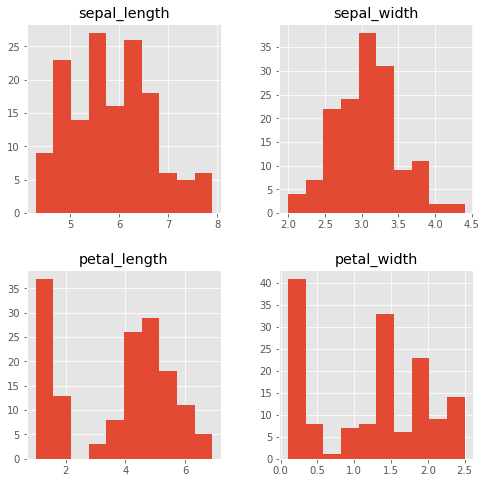

In [32]:
pd_iris.hist(figsize=(8, 8))

array([[<AxesSubplot:xlabel='sepal_length', ylabel='sepal_length'>,
        <AxesSubplot:xlabel='sepal_width', ylabel='sepal_length'>,
        <AxesSubplot:xlabel='petal_length', ylabel='sepal_length'>,
        <AxesSubplot:xlabel='petal_width', ylabel='sepal_length'>],
       [<AxesSubplot:xlabel='sepal_length', ylabel='sepal_width'>,
        <AxesSubplot:xlabel='sepal_width', ylabel='sepal_width'>,
        <AxesSubplot:xlabel='petal_length', ylabel='sepal_width'>,
        <AxesSubplot:xlabel='petal_width', ylabel='sepal_width'>],
       [<AxesSubplot:xlabel='sepal_length', ylabel='petal_length'>,
        <AxesSubplot:xlabel='sepal_width', ylabel='petal_length'>,
        <AxesSubplot:xlabel='petal_length', ylabel='petal_length'>,
        <AxesSubplot:xlabel='petal_width', ylabel='petal_length'>],
       [<AxesSubplot:xlabel='sepal_length', ylabel='petal_width'>,
        <AxesSubplot:xlabel='sepal_width', ylabel='petal_width'>,
        <AxesSubplot:xlabel='petal_length', ylabel='petal_

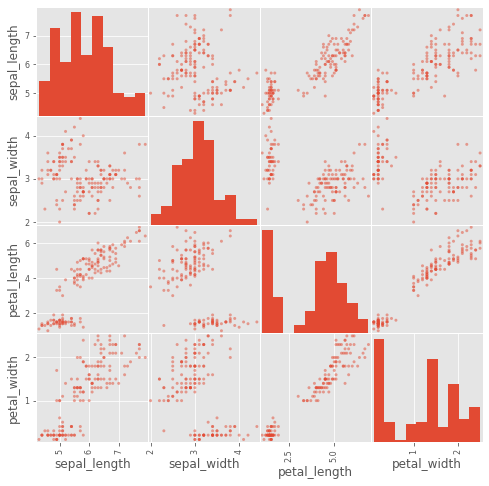

In [33]:
scatter_matrix(pd_iris, figsize=(8, 8))

### Prepping features

It is common to go through stages of feature engineering that involve transformation, scaling, indexing, and similar steps.  MLlib provides a `Pipeline` to assemble these steps.

In [22]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import IndexToString, StringIndexer, VectorAssembler

First, we pull our features into a feature vector using a `VectorAssembler`.

In [23]:
assembler = VectorAssembler(inputCols=["sepal_length", "sepal_width",
                                       "petal_length", "petal_width"],
                            outputCol="features")

Next, we want to have our various target labels in `class` indexed to numeric category values.  The MLlib `StringIndexer` can turn these string values into a numeric representation of categories.

In [25]:
indexer = StringIndexer(inputCol="class", outputCol="labelIndex").fit(iris)

Next, we prep our model:

In [26]:
rf = RandomForestClassifier(labelCol="labelIndex", featuresCol="features", numTrees=10)

And we're going to need to be able to get those class labels back:

In [27]:
labeler = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                        labels=indexer.labels)

Finally, we assemble all of these steps into a `Pipeline`:

In [28]:
pipeline = Pipeline(stages=[assembler, indexer, rf, labeler])

### Split data into training and test sets

We always want to hold out some data from training so we can get an honest assessment on how our model will perform with unseen data.  Fortunately there's an easy API call for this.

In [40]:
help(iris.randomSplit)

Help on method randomSplit in module pyspark.sql.dataframe:

randomSplit(weights, seed=None) method of pyspark.sql.dataframe.DataFrame instance
    Randomly splits this :class:`DataFrame` with the provided weights.
    
    .. versionadded:: 1.4.0
    
    Parameters
    ----------
    weights : list
        list of doubles as weights with which to split the :class:`DataFrame`.
        Weights will be normalized if they don't sum up to 1.0.
    seed : int, optional
        The seed for sampling.
    
    Examples
    --------
    >>> splits = df4.randomSplit([1.0, 2.0], 24)
    >>> splits[0].count()
    2
    
    >>> splits[1].count()
    2



In [30]:
train, test = iris.randomSplit([0.6, 0.4], 42)

In [31]:
train.count()

87

In [32]:
test.count()

63

Looks good.  We'll use `train` to build our model, and leave `test` alone for now.

### Train the model and get predictions

In [33]:
model = pipeline.fit(train)

In [34]:
predictions = model.transform(test)

In [35]:
predictions.select("predictedLabel", "class", "features").show()

+---------------+---------------+-----------------+
| predictedLabel|          class|         features|
+---------------+---------------+-----------------+
|    Iris-setosa|    Iris-setosa|[4.3,3.0,1.1,0.1]|
|    Iris-setosa|    Iris-setosa|[4.4,3.0,1.3,0.2]|
|    Iris-setosa|    Iris-setosa|[4.5,2.3,1.3,0.3]|
|    Iris-setosa|    Iris-setosa|[4.6,3.2,1.4,0.2]|
|    Iris-setosa|    Iris-setosa|[4.6,3.6,1.0,0.2]|
|    Iris-setosa|    Iris-setosa|[4.7,3.2,1.3,0.2]|
|    Iris-setosa|    Iris-setosa|[4.8,3.0,1.4,0.1]|
|    Iris-setosa|    Iris-setosa|[4.8,3.1,1.6,0.2]|
|    Iris-setosa|    Iris-setosa|[4.8,3.4,1.6,0.2]|
|    Iris-setosa|    Iris-setosa|[4.8,3.4,1.9,0.2]|
|Iris-versicolor| Iris-virginica|[4.9,2.5,4.5,1.7]|
|    Iris-setosa|    Iris-setosa|[4.9,3.1,1.5,0.1]|
|    Iris-setosa|    Iris-setosa|[4.9,3.1,1.5,0.1]|
|Iris-versicolor|Iris-versicolor|[5.0,2.3,3.3,1.0]|
|    Iris-setosa|    Iris-setosa|[5.0,3.0,1.6,0.2]|
|    Iris-setosa|    Iris-setosa|[5.0,3.4,1.6,0.4]|
|    Iris-se

In [36]:
for metric in ['accuracy', 'f1']:
    evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex",
                                                  predictionCol="prediction",
                                                  metricName=metric)
    print("{}: {}".format(metric, evaluator.evaluate(predictions)))

accuracy: 0.9523809523809523
f1: 0.9524139524139523


In [37]:
model.stages

[VectorAssembler_5710716a57c6,
 StringIndexerModel: uid=StringIndexer_403f7b4a349d, handleInvalid=error,
 RandomForestClassificationModel: uid=RandomForestClassifier_a352dfa3883b, numTrees=10, numClasses=3, numFeatures=4,
 IndexToString_b89c5c89e92a]

In [38]:
s2 = model.stages[2]

In [39]:
s2.trees

[DecisionTreeClassificationModel: uid=dtc_c095ef5b650b, depth=4, numNodes=11, numClasses=3, numFeatures=4,
 DecisionTreeClassificationModel: uid=dtc_f7c25e56ee85, depth=4, numNodes=15, numClasses=3, numFeatures=4,
 DecisionTreeClassificationModel: uid=dtc_c31f0322fb67, depth=4, numNodes=15, numClasses=3, numFeatures=4,
 DecisionTreeClassificationModel: uid=dtc_87fbb95a0685, depth=5, numNodes=19, numClasses=3, numFeatures=4,
 DecisionTreeClassificationModel: uid=dtc_f3bfb59510b3, depth=4, numNodes=9, numClasses=3, numFeatures=4,
 DecisionTreeClassificationModel: uid=dtc_7d2a0d3bcc1b, depth=4, numNodes=13, numClasses=3, numFeatures=4,
 DecisionTreeClassificationModel: uid=dtc_c43c7f6607e2, depth=5, numNodes=17, numClasses=3, numFeatures=4,
 DecisionTreeClassificationModel: uid=dtc_4557a8dd770a, depth=4, numNodes=13, numClasses=3, numFeatures=4,
 DecisionTreeClassificationModel: uid=dtc_c31e983429ac, depth=3, numNodes=11, numClasses=3, numFeatures=4,
 DecisionTreeClassificationModel: uid=

In [40]:
for t in s2.trees:
    print(t.toDebugString)

DecisionTreeClassificationModel: uid=dtc_c095ef5b650b, depth=4, numNodes=11, numClasses=3, numFeatures=4
  If (feature 2 <= 2.5999999999999996)
   Predict: 0.0
  Else (feature 2 > 2.5999999999999996)
   If (feature 0 <= 5.95)
    If (feature 3 <= 1.85)
     Predict: 1.0
    Else (feature 3 > 1.85)
     Predict: 2.0
   Else (feature 0 > 5.95)
    If (feature 3 <= 1.7000000000000002)
     If (feature 2 <= 4.95)
      Predict: 1.0
     Else (feature 2 > 4.95)
      Predict: 2.0
    Else (feature 3 > 1.7000000000000002)
     Predict: 2.0

DecisionTreeClassificationModel: uid=dtc_f7c25e56ee85, depth=4, numNodes=15, numClasses=3, numFeatures=4
  If (feature 0 <= 6.25)
   If (feature 3 <= 0.75)
    Predict: 0.0
   Else (feature 3 > 0.75)
    If (feature 3 <= 1.7000000000000002)
     Predict: 1.0
    Else (feature 3 > 1.7000000000000002)
     If (feature 0 <= 5.95)
      Predict: 1.0
     Else (feature 0 > 5.95)
      Predict: 2.0
  Else (feature 0 > 6.25)
   If (feature 3 <= 1.55)
    Predict